In [439]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from skimage import measure
from skimage.io import imread, imshow
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import rgb2gray
from PIL import Image
from PIL import ImageDraw, ImageOps
import fnmatch
import csv
from pandas import DataFrame
import sys
from scipy.ndimage import rotate
from scipy.stats import sem
import seaborn as sns

from skimage import io, filters
from scipy import ndimage
import cv2
import os


import warnings
warnings.filterwarnings('ignore')

save_dir = '/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/replicates_results/single_cell_analysis_revision/'

In [549]:
from pathlib import Path
import pandas as pd

# Point to the mounted share on macOS (adjust this base to your folder)
data_dir = Path("/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep2/pos_14/tracking_strong_filters")

csv_path  = data_dir / "trackmate_spots.csv"
mask_path = data_dir / "mask.tif"

# Sanity checks so you fail early with a clear message
if not csv_path.exists():
    raise FileNotFoundError(f"Not found: {csv_path} — is the share mounted and path correct?")
if not mask_path.exists():
    raise FileNotFoundError(f"Not found: {mask_path} — check the filename/extension.")

# Load the CSV
df = pd.read_csv(csv_path)

# --- OPTION A (recommended): use tifffile to preserve dtype/metadata ---
try:
    import tifffile as tiff
    mask = tiff.imread(mask_path)
except ImportError:
    # --- OPTION B: fallback to matplotlib.image (works for many TIFFs) ---
    import matplotlib.image as mpimg
    mask = mpimg.imread(mask_path)


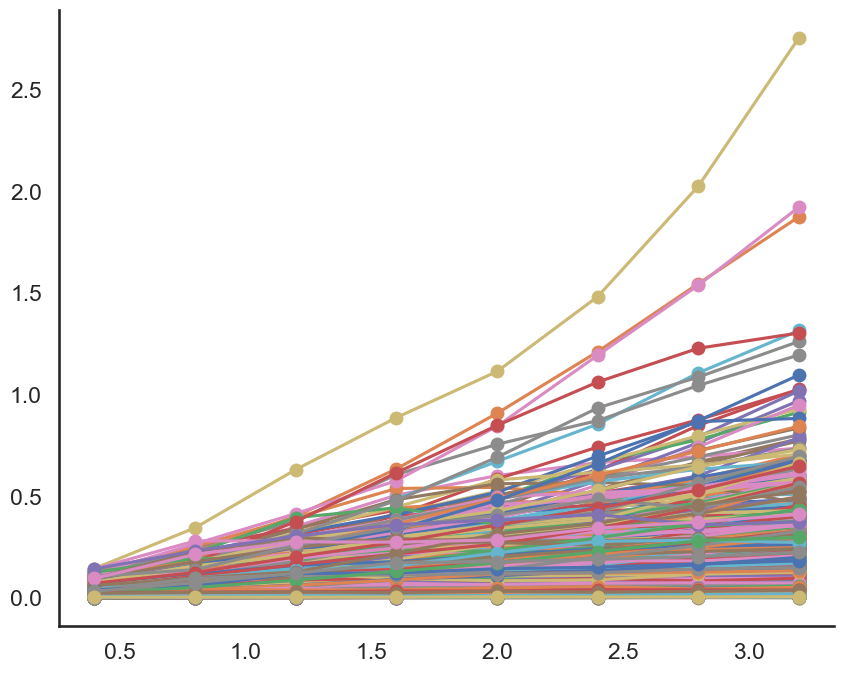

In [551]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- helpers (same as you had) ---
def msd_function(t, D, alpha):
    return 4 * D * (t ** alpha)

def calculate_alpha(msd_values, time_intervals):
    initial_guess = [1.0, 1.0]
    params, _ = curve_fit(msd_function, np.asarray(time_intervals, dtype=float), np.asarray(msd_values, dtype=float), p0=initial_guess)
    return float(params[1])

def calculate_msd(x, y, max_tau):
    N = len(x)
    msd_values = []
    for tau in range(1, max_tau + 1):
        sq = []
        for i in range(N - tau):
            dx = x[i + tau] - x[i]
            dy = y[i + tau] - y[i]
            sq.append(dx*dx + dy*dy)
        msd_values.append(np.mean(sq) if len(sq) else np.nan)
    return msd_values

# --- order tracks & add time column ---
grouped_by_tracks = df.groupby('TRACK_ID')
ordered_tracks = grouped_by_tracks.apply(lambda x: x.sort_values(by='FRAME'))
ordered_tracks.reset_index(drop=True, inplace=True)

# imaging interval (s) — adjust if needed
delta_t = 0.4
ordered_tracks['Time (s)'] = delta_t * (1 + ordered_tracks.groupby('TRACK_ID').cumcount())
grouped_by_tracks = ordered_tracks.groupby('TRACK_ID')

# --- compute MSD per track (no .append) ---
max_tau = 8
msd_records = []   # will hold rows for msd_df
plot_t = np.arange(1, max_tau + 1) * delta_t

plt.figure(figsize=(10, 8))
for track_id, group in grouped_by_tracks:
    x = group['POSITION_X'].to_numpy()
    y = group['POSITION_Y'].to_numpy()
    msd_values = calculate_msd(x, y, max_tau)
    time_intervals = np.arange(1, max_tau + 1, dtype=float) * delta_t

    # add record for this track
    msd_records.append({
        'TRACK_ID': track_id,
        'MSD': np.asarray(msd_values, dtype=float),
        'time_intervals': time_intervals,
    })

    # plot
    plt.plot(plot_t, msd_values, marker='o')

msd_df = pd.DataFrame(msd_records)

# --- fit alpha per track ---
msd_df['alpha'] = msd_df.apply(lambda r: calculate_alpha(r['MSD'], r['time_intervals']), axis=1)

# classify diffusion type (unchanged thresholds)
normal_df  = msd_df[(msd_df['alpha'] > 0.8) & (msd_df['alpha'] < 1.2)].copy()
super_df   = msd_df[(msd_df['alpha'] >= 1.2)].copy()
confined_df= msd_df[(msd_df['alpha'] <= 0.8)].copy()

normal_df['type of diffusion']   = 'normal'
super_df['type of diffusion']    = 'super'
confined_df['type of diffusion'] = 'confined'

combined_msd_df = pd.concat([normal_df, super_df, confined_df], ignore_index=True)

# --- compute D per τ with alpha on τ, then summarize D per track (median is robust) ---
def per_tau_D(row):
    msd_vals = np.asarray(row['MSD'], dtype=float)
    taus = np.asarray(row['time_intervals'], dtype=float)
    a = float(row['alpha'])
    return msd_vals / (4.0 * (taus ** a))

msd_df['D_per_tau'] = msd_df.apply(per_tau_D, axis=1)
msd_df['D_median'] = msd_df['D_per_tau'].apply(lambda arr: np.nanmedian(arr))

# this replaces your prior 'grouped_diffusion' that used α=1
grouped_diffusion = (
    msd_df[['TRACK_ID', 'D_median']]
    .rename(columns={'D_median': 'Diffusion_Coefficient'})
)




### Fit for alpha to define the type of diffusion (normal, confined, directed motion)

In [553]:
# --- NEW: compute per-τ diffusion coefficients with alpha on tau ---
import numpy as np

# D(τ) = MSD(τ) / [4 * (τΔt)^α]
msd_df['D_per_tau'] = msd_df.apply(
    lambda r: np.asarray(r['MSD']) / (4.0 * (np.asarray(r['time_intervals']) ** float(r['alpha']))),
    axis=1
)

# Choose a single D per track (median across τ is robust; adjust if you prefer first-lag, linear window, etc.)
msd_df['D_median'] = msd_df['D_per_tau'].apply(lambda arr: np.nanmedian(arr))

# Build grouped_diffusion from this consistent definition
grouped_diffusion = (
    msd_df[['TRACK_ID', 'D_median']]
    .rename(columns={'D_median': 'Diffusion_Coefficient'})
    .drop_duplicates(subset=['TRACK_ID'])
)


normal_df = msd_df[(msd_df['alpha'] > 0.8) & (msd_df['alpha'] < 1.2)]
super_df = msd_df[(msd_df['alpha'] >= 1.2)]
confined_df = msd_df[(msd_df['alpha'] <= 0.8)]

normal_df['type of diffusion'] = 'normal'
super_df['type of diffusion'] = 'super'
confined_df['type of diffusion'] = 'confined'

# Concatenate the three DataFrames into a single DataFrame
combined_msd_df = pd.concat([normal_df, super_df, confined_df], ignore_index=True)
combined_msd_diffusion_df = pd.merge(combined_msd_df, grouped_diffusion, on='TRACK_ID')

#Conveet diffusion coefficient to nm/s
combined_msd_diffusion_df['Diffusion_Coefficient'] = combined_msd_diffusion_df['Diffusion_Coefficient']

#combined_msd_diffusion_df.to_csv(data_dir+'diffusion_analysis.csv', index=None)
coordinates_df = pd.merge(combined_msd_diffusion_df, df, on='TRACK_ID')

### Attribute tracks to single cells

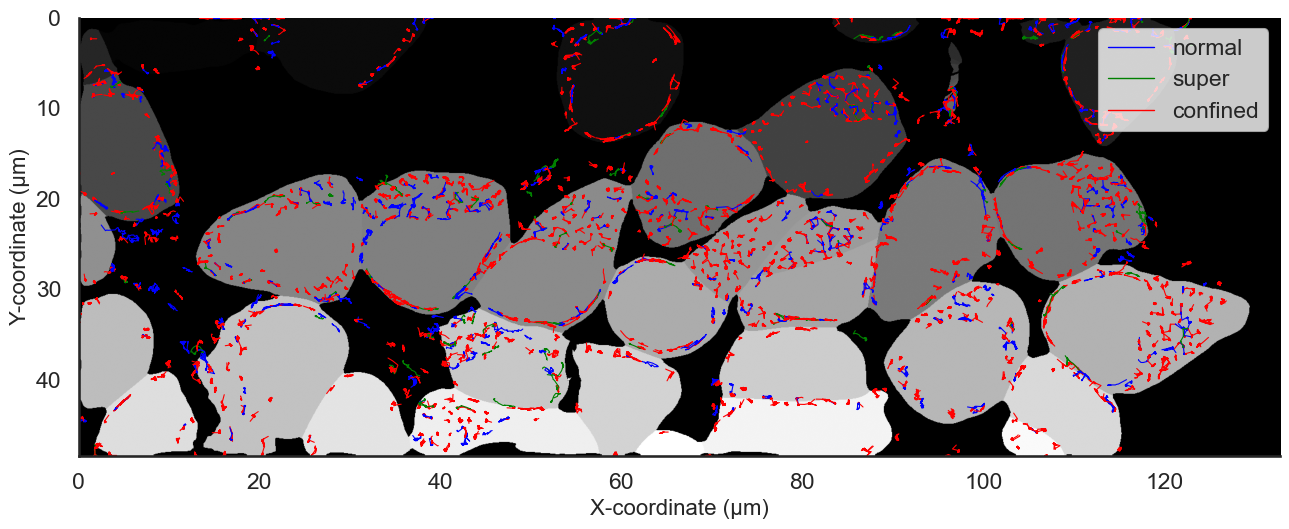

In [555]:
# Get information from dapi image
label_mask = label(mask)
        
#assign a specific array to single cells
max_number_of_cells = np.amax(label_mask) 

cells_array = np.arange(1, max_number_of_cells + 1) 

# Reflect the image vertically
reflected_image = np.flipud(label_mask)

# Define a dictionary mapping diffusion types to colors
diffusion_colors = {'normal': 'blue', 'super': 'green', 'confined': 'red'}

# Determine the conversion factor
conversion_factor = 15.4083  # pixels to micrometers

# Determine the extent of the image
height, width = reflected_image.shape
extent_image = [0, width / conversion_factor, 0, height / conversion_factor]  # extent in micrometers

# Create a figure and plot the reflected image
plt.figure(figsize=(15.5, 10))
plt.imshow(reflected_image, cmap='gray', origin='upper', extent=extent_image)

# Plot all tracks
for track_id, track_data in coordinates_df.groupby('TRACK_ID'):
    # Sort track data by the frame column
    track_data_sorted = track_data.sort_values(by='FRAME')
    
    # Get the diffusion type for the track
    diffusion_type = track_data_sorted['type of diffusion'].iloc[0]
    
    # Get the color corresponding to the diffusion type
    color = diffusion_colors.get(diffusion_type, 'black')
    
    # Plot the track with the determined color, connecting dots in the order of the frame column
    plt.plot(track_data_sorted['POSITION_X'], track_data_sorted['POSITION_Y'], color=color, linewidth=0.8)

# Add legend for diffusion types
legend_elements = [mlines.Line2D([0], [0], color=color, lw=1, label=diffusion_type) for diffusion_type, color in diffusion_colors.items()]
plt.legend(handles=legend_elements, loc='upper right')

# Set labels and title
plt.xlabel('X-coordinate (µm)', fontsize=16)
plt.ylabel('Y-coordinate (µm)', fontsize=16)

plt.gca().invert_yaxis()  # Invert Y-axis
#plt.savefig(data_dir + 'tracks_overlay.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [557]:
from pathlib import Path
import numpy as np
import pandas as pd
from skimage.measure import regionprops


conversion_factor = 15.4083

# Reflect (if needed) and compute physical extent (µm). If mask is RGB, take first two dims.
reflected_image = np.flipud(mask)
h, w = reflected_image.shape[:2]
reflected_extent_image = [0, w / conversion_factor, 0, h / conversion_factor]  # [xmin, xmax, ymin, ymax] in µm

# Precompute regionprops once and map label -> bbox (in µm)
props = regionprops(label_mask)
bbox_um_by_label = {
    r.label: tuple(c / conversion_factor for c in r.bbox)  # (minr, minc, maxr, maxc) in µm
    for r in props
}

# Sanity check that coordinate units match (POSITION_* should be in µm)
# If POSITION_* are in pixels, remove '/ conversion_factor' above and convert X/Y instead.

measurements = []

# Group tracks once
tracks = list(coordinates_df.groupby('TRACK_ID'))

for cell in cells_array:
    bbox_um = bbox_um_by_label.get(cell)
    if bbox_um is None:
        continue  # label not present

    minr_um, minc_um, maxr_um, maxc_um = bbox_um

    # For each track, check if any point falls inside this cell's bbox
    for track_id, track_df in tracks:
        # boolean mask for points inside the bbox (vectorized)
        inside = (
            track_df['POSITION_X'].between(minc_um, maxc_um)
            & track_df['POSITION_Y'].between(minr_um, maxr_um)
        )
        if inside.any():
            measurements.append({
                'cell_id': cell,
                'track_id': track_id,
                'type_of_diffusion': track_df['type of diffusion'].iloc[0],
                'diffusion_coefficient': track_df['Diffusion_Coefficient'].iloc[0],
            })

measurements_df = pd.DataFrame(measurements)

# --- SAVE: use pathlib join, not '+' ---
out_path = data_dir / "track_analysis_single_cell_1.csv"
measurements_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Saved: /Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep2/pos_14/tracking_strong_filters/track_analysis_single_cell_1.csv


### Filter masks by area

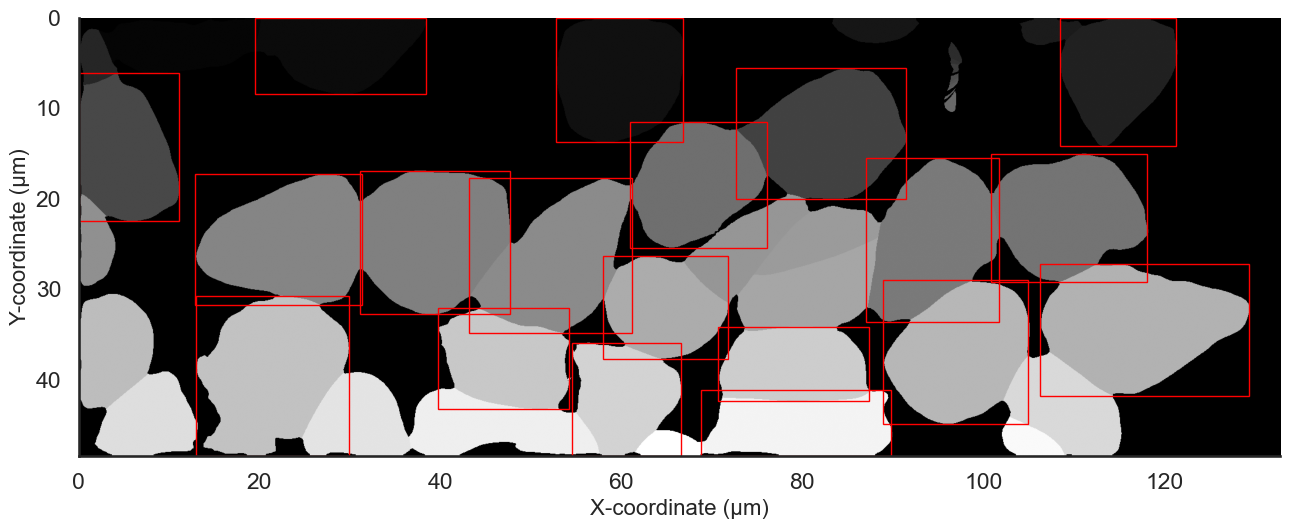

In [559]:
label_mask = label(mask)

# Assign a specific array to single cells
max_number_of_cells = np.amax(label_mask)
cells_array = np.arange(1, max_number_of_cells + 1)

# Reflect the image vertically
reflected_image = np.flipud(label_mask)

# Define a dictionary mapping diffusion types to colors
diffusion_colors = {'normal': 'blue', 'super': 'green', 'confined': 'red'}

# Determine the conversion factor
conversion_factor = 15.4083  # pixels to micrometers

# Determine the extent of the image
height, width = reflected_image.shape
extent_image = [0, width / conversion_factor, 0, height / conversion_factor]  # extent in micrometers

# Create a figure and plot the reflected image
plt.figure(figsize=(15.5, 10))
plt.imshow(reflected_image, cmap='gray', origin='upper', extent=extent_image)

# Create an empty list to store valid cell labels
valid_cell_labels = []

# Iterate through each cell in the labeled mask
for cell in cells_array:
    # Get the properties of the region corresponding to the current cell
    region_props = regionprops(label_mask)
    
    # Find the region with label equal to the current cell
    for region in region_props:
        if region.label == cell:
            # Measure the area of the current cell and convert it to micrometers squared
            cell_area = region.area * (conversion_factor ** 2)
            
            # Set a threshold for the cell area (e.g., 100 square micrometers)
            area_threshold = 6000000
            
            # Check if the area is larger than the threshold
            if cell_area >= area_threshold:
                valid_cell_labels.append(cell)
                break  # Move to the next cell

# Plot only the cells with valid areas
for region in region_props:
    if region.label in valid_cell_labels:
        # Get the bounding box coordinates of the current cell and convert them to micrometers
        minr_scaled, minc_scaled, maxr_scaled, maxc_scaled = [coord / conversion_factor for coord in region.bbox]
        
        # Plot a rectangle representing the cell on the image
        rect = plt.Rectangle((minc_scaled, minr_scaled), maxc_scaled - minc_scaled, maxr_scaled - minr_scaled,
                             fill=False, edgecolor='red', linewidth=1)
        plt.gca().add_patch(rect)

# Set labels and title
plt.xlabel('X-coordinate (µm)', fontsize=16)
plt.ylabel('Y-coordinate (µm)', fontsize=16)
plt.gca().invert_yaxis()  # Invert Y-axis
plt.show()

In [561]:
from pathlib import Path
import numpy as np
import pandas as pd
from skimage.measure import regionprops

# --- paths ---
data_dir = Path("/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep2/pos_14/tracking_strong_filters")

# --- units ---
# conversion_factor is pixels per micrometer (px/µm)
conversion_factor = 15.4083

# --- sanity on mask/label mask extent (optional, keep if you plot) ---
reflected_image = np.flipud(mask)
h, w = reflected_image.shape[:2]
reflected_extent_image = [0, w / conversion_factor, 0, h / conversion_factor]  # in µm

# --- region properties once ---
props = regionprops(label_mask)

# Build label -> info (bbox in µm, area in µm²)
label_info = {
    r.label: {
        "bbox_um": tuple(coord / conversion_factor for coord in r.bbox),  # (minr, minc, maxr, maxc) in µm
        "area_um2": (r.area / (conversion_factor ** 2)),                  # convert px² -> µm² (DIVIDE)
    }
    for r in props
}

# If you don't already have cells_array, derive it from labels >0
if 'cells_array' not in locals():
    cells_array = [lab for lab in label_info.keys() if lab != 0]

# --- choose thresholds robustly from the data ---
all_areas = np.array([info["area_um2"] for info in label_info.values() if info["area_um2"] > 0])

if all_areas.size == 0:
    raise ValueError("No positive areas found in label_mask. Check that label_mask contains labeled cells.")

# Data-driven limits (tweak percentiles if needed)
min_area_um2 = float(np.percentile(all_areas, 5))     # ignore tiny specks
max_area_um2 = float(np.percentile(all_areas, 99.5))  # ignore extreme outliers

# Optional: set absolute floors/ceilings (uncomment to force)
# ABS_MIN = 100.0          # µm²
# ABS_MAX = 1_000_000.0    # µm²
# min_area_um2 = max(min_area_um2, ABS_MIN)
# max_area_um2 = min(max_area_um2, ABS_MAX)

print(f"[Area filter] Using {min_area_um2:.1f} ≤ area (µm²) ≤ {max_area_um2:.1f}")
print(f"[Area stats] n={len(all_areas)}, median={np.median(all_areas):.1f}, "
      f"p5={np.percentile(all_areas,5):.1f}, p95={np.percentile(all_areas,95):.1f}")

# --- group tracks once ---
tracks = list(coordinates_df.groupby('TRACK_ID'))

measurements = []

kept_labels = 0
for cell in cells_array:
    info = label_info.get(cell)
    if info is None:
        continue

    area = info["area_um2"]
    if not (min_area_um2 <= area <= max_area_um2):
        continue  # filtered out by area

    kept_labels += 1
    minr_um, minc_um, maxr_um, maxc_um = info["bbox_um"]

    # test overlap: any point of a track inside the bbox
    for track_id, track_df in tracks:
        inside = (
            track_df['POSITION_X'].between(minc_um, maxc_um)
            & track_df['POSITION_Y'].between(minr_um, maxr_um)
        )
        if inside.any():
            measurements.append({
                'cell_id': cell,
                'track_id': track_id,
                'type_of_diffusion': track_df['type of diffusion'].iloc[0],
                'diffusion_coefficient': track_df['Diffusion_Coefficient'].iloc[0],
            })

print(f"[Filter] Kept {kept_labels} labeled regions after area filtering.")

measurements_df = pd.DataFrame(measurements)

# If nothing made it through, relax the filter once to avoid empty output
if measurements_df.empty:
    print("[Warn] No overlaps found after area filtering. Relaxing to keep all areas.")
    measurements = []
    for cell in cells_array:
        info = label_info.get(cell)
        if info is None:
            continue
        minr_um, minc_um, maxr_um, maxc_um = info["bbox_um"]
        for track_id, track_df in tracks:
            inside = (
                track_df['POSITION_X'].between(minc_um, maxc_um)
                & track_df['POSITION_Y'].between(minr_um, maxr_um)
            )
            if inside.any():
                measurements.append({
                    'cell_id': cell,
                    'track_id': track_id,
                    'type_of_diffusion': track_df['type of diffusion'].iloc[0],
                    'diffusion_coefficient': track_df['Diffusion_Coefficient'].iloc[0],
                })
    measurements_df = pd.DataFrame(measurements)
    print(f"[Relaxed] Rows after skipping area filter: {len(measurements_df)}")

# --- save ---
out_path = data_dir / "track_analysis_single_cell_filtered_by_area_1.csv"
measurements_df.to_csv(out_path, index=False)
print(f"Saved: {out_path} (rows={len(measurements_df)})")


[Area filter] Using 0.1 ≤ area (µm²) ≤ 218.0
[Area stats] n=46, median=83.0, p5=0.1, p95=202.5
[Filter] Kept 42 labeled regions after area filtering.
Saved: /Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep2/pos_14/tracking_strong_filters/track_analysis_single_cell_filtered_by_area_1.csv (rows=2421)


In [563]:
data_dir = "/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep2/pos_14/tracking_strong_filters/"

In [565]:
file_path1 = data_dir + 'track_analysis_single_cell_filtered_by_area_1.csv'
file_path2 = data_dir + 'track_analysis_single_cell_1.csv'

# Load CSV files
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Divide "Diffusion_Coefficient" column by 1000
df1['diffusion_coefficient'] /= 1000
df2['diffusion_coefficient'] /= 1000

# Save the modified DataFrames by overwriting the original files
df1.to_csv(file_path1, index=False)
df2.to_csv(file_path2, index=False)

### Combine replicates

In [567]:
base_dir_rep1 = r'/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep1/'

# List of positions
positions_rep1 = ['pos_4', 'pos_5', 'pos_6', 'pos_7', 'pos_8', 'pos_9', 'pos_10', 'pos_11']

# Initialize an empty list to store DataFrames
dfs_rep1 = []

# Iterate over positions
for pos in positions_rep1:
    # Construct the full path to the CSV file
    csv_path = os.path.join(base_dir_rep1, pos, 'tracking_strong_filters', 'track_analysis_single_cell_filtered_by_area_1.csv')
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Create a new column combining 'cell_id' with 'pos'
    df['cell_id_pos'] = df['cell_id'].astype(str) + '_' + pos
    
    # Append the DataFrame to the list
    dfs_rep1.append(df)

# Concatenate all DataFrames in the list along the rows
concatenated_df_rep1 = pd.concat(dfs_rep1, ignore_index=True)


In [569]:
base_dir_rep2 = r'/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep2/'

# List of positions
positions_rep2 = ['pos_1', 'pos_2', 'pos_3', 'pos_4', 'pos_12', 'pos_13', 'pos_14']

# Initialize an empty list to store DataFrames
dfs_rep2 = []

# Iterate over positions
for pos in positions_rep2:
    # Construct the full path to the CSV file
    csv_path = os.path.join(base_dir_rep2, pos, 'tracking_strong_filters', 'track_analysis_single_cell_filtered_by_area_1.csv')
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Create a new column combining 'cell_id' with 'pos'
    df['cell_id_pos'] = df['cell_id'].astype(str) + '_' + pos
    
    # Append the DataFrame to the list
    dfs_rep2.append(df)

# Concatenate all DataFrames in the list along the rows
concatenated_df_rep2 = pd.concat(dfs_rep2, ignore_index=True)
concatenated_df_rep2

cell_id  track_id type_of_diffusion  diffusion_coefficient cell_id_pos
0            1       126            normal               0.000018     1_pos_1
1            1      2576          confined               0.000012     1_pos_1
2            1      2792          confined               0.000019     1_pos_1
3            1      4061          confined               0.000011     1_pos_1
4            1      6756            normal               0.000006     1_pos_1
...        ...       ...               ...                    ...         ...
12916       45     16740          confined               0.000007   45_pos_14
12917       45     20982          confined               0.000016   45_pos_14
12918       45     23866          confined               0.000003   45_pos_14
12919       45     24191          confined               0.000007   45_pos_14
12920       46      2766          confined               0.000009   46_pos_14

[12921 rows x 5 columns]

In [571]:
##Check how many cells are left
grouped_data = concatenated_df_rep2.groupby(['cell_id_pos'])['diffusion_coefficient'].mean().reset_index()
len(grouped_data)

193

In [573]:
color_palette = sns.color_palette("YlGnBu")

In [607]:
import pandas as pd
import numpy as np

# Start from grouped_data (cell_id_pos x type_of_diffusion_rep mean)
# If you don't have grouped_data, rebuild it from concatenated_df:
if 'grouped_data' not in locals():
    grouped_data = (
        concatenated_df
        .groupby(['cell_id_pos', 'type_of_diffusion_rep'])['diffusion_coefficient']
        .mean()
        .reset_index()
    )

# Harmonize column name just in case
if 'Diffusion_Coefficient' in grouped_data.columns and 'diffusion_coefficient' not in grouped_data.columns:
    grouped_data = grouped_data.rename(columns={'Diffusion_Coefficient': 'diffusion_coefficient'})

# Create the columns your plot expects
df = grouped_data.copy()
df['type_of_diffusion_rep'] = df['type_of_diffusion_rep'].astype(str).str.strip()
df['type'] = df['type_of_diffusion_rep'].str.replace(r'_rep[12]$', '', regex=True)      # confined/normal/super
df['rep']  = df['type_of_diffusion_rep'].str.extract(r'_(rep\d+)$')[0]                  # rep1/rep2
df['diffusion_coefficient'] = pd.to_numeric(df['diffusion_coefficient'], errors='coerce')
df = df.dropna(subset=['diffusion_coefficient', 'type', 'rep'])


Saved to:
- /Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/replicates_results/single_cell_analysis_revision/boxplot_diffusion_by_group.svg


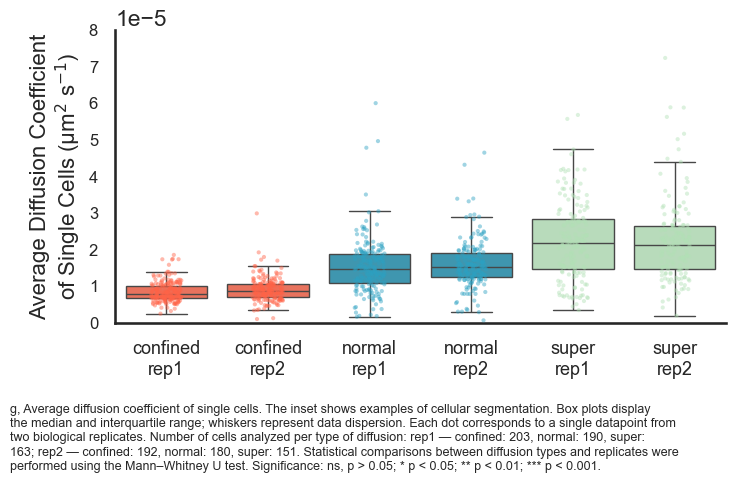

In [617]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ---- order & palette ----
order = ['confined_rep1','confined_rep2','normal_rep1','normal_rep2','super_rep1','super_rep2']
colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato'}
palette_cat = {cat: colors[cat.split('_')[0]] for cat in order}

# ---- adjustable y-axis controls ----
yscale = 'linear'   # 'linear' or 'log'
ymin   = 0
ymax   = 0.00008

# ---- plot ----
sns.set_theme(context="talk", style="white")
sns.set_style({"axes.spines.right": False, "axes.spines.top": False})

fig, ax = plt.subplots(figsize=(7.5, 5))

sns.boxplot(
    data=df, x='type_of_diffusion_rep', y='diffusion_coefficient',
    order=[c for c in order if c in df['type_of_diffusion_rep'].unique()],
    palette=palette_cat, linewidth=1, showfliers=False, ax=ax
)

sns.stripplot(
    data=df, x='type_of_diffusion_rep', y='diffusion_coefficient',
    order=[c for c in order if c in df['type_of_diffusion_rep'].unique()],
    palette=palette_cat, jitter=0.15, alpha=0.45, size=3, linewidth=0, ax=ax
)

ax.set_xticklabels([t.get_text().replace('_', '\n') for t in ax.get_xticklabels()])

ax.set_yscale(yscale)
if ymin is not None or ymax is not None:
    lo = ymin if ymin is not None else ax.get_ylim()[0]
    hi = ymax if ymax is not None else ax.get_ylim()[1]
    ax.set_ylim(lo, hi)

ax.set_xlabel('')
ax.set_ylabel('Average Diffusion Coefficient\nof Single Cells (µm$^2$ s$^{-1}$)', fontsize=16)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=12)
sns.despine(ax=ax)
fig.tight_layout()

from textwrap import fill

# --- compute N per diffusion type per replicate from df ---
# df must have columns: ['type'] in {'confined','normal','super'} and ['rep'] in {'rep1','rep2'}
counts = (df.groupby(['rep','type'])
            .size()
            .unstack(fill_value=0)
            .reindex(index=['rep1','rep2'], columns=['confined','normal','super'])
            .fillna(0)
            .astype(int))

n_c1, n_n1, n_s1 = counts.loc['rep1', ['confined','normal','super']].tolist()
n_c2, n_n2, n_s2 = counts.loc['rep2', ['confined','normal','super']].tolist()

# --- build caption text ---
caption = (
    "g, Average diffusion coefficient of single cells. The inset shows examples of cellular segmentation. "
    "Box plots display the median and interquartile range; whiskers represent data dispersion. "
    "Each dot corresponds to a single datapoint from two biological replicates. "
    f"Number of cells analyzed per type of diffusion: rep1 — confined: {n_c1}, normal: {n_n1}, super: {n_s1}; "
    f"rep2 — confined: {n_c2}, normal: {n_n2}, super: {n_s2}. "
    "Statistical comparisons between diffusion types and replicates were performed using the Mann–Whitney U test. "
    "Significance: ns, p > 0.05; * p < 0.05; ** p < 0.01; *** p < 0.001."
)

# --- place caption under plot ---
wrapped = fill(caption, width=120)
# make room at bottom for caption
fig.subplots_adjust(bottom=0.32)  # increase if caption gets clipped
fig.text(0.01, 0.02, wrapped, ha='left', va='bottom', fontsize=9)


# ---- SAVE FIGURES ----
save_dir = Path("/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/replicates_results/single_cell_analysis_revision/")  
save_dir.mkdir(parents=True, exist_ok=True)
fname = "boxplot_diffusion_by_group"


fig.savefig(save_dir / f"{fname}.svg",               bbox_inches="tight", transparent=True)
print(f"Saved to:\n- {save_dir / (fname + '.svg')}")

plt.show()



In [621]:
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path

# Expect df with columns: 'type' in {'confined','normal','super'}, 'rep' in {'rep1','rep2'}, 
# and numeric 'diffusion_coefficient'

def cliffs_delta(a, b):
    a = np.asarray(pd.to_numeric(a, errors='coerce').dropna(), float)
    b = np.asarray(pd.to_numeric(b, errors='coerce').dropna(), float)
    if len(a) == 0 or len(b) == 0: return np.nan
    diff = a[:, None] - b[None, :]
    return (np.sum(diff > 0) - np.sum(diff < 0)) / (len(a) * len(b))

def fdr_bh(pvals):
    try:
        from statsmodels.stats.multitest import multipletests
        if len(pvals) == 0:
            return []
        _, p_fdr, _, _ = multipletests(pvals, method='fdr_bh')
        return list(p_fdr)
    except Exception:
        m = max(1, len(pvals))  # Bonferroni fallback
        return [min(1.0, p*m) for p in pvals]

def star(p):
    if not np.isfinite(p): return 'n/a'
    return '****' if p < 1e-4 else ('***' if p < 1e-3 else ('**' if p < 1e-2 else ('*' if p < 5e-2 else 'ns')))

# ---------- 1) Replicate vs Replicate (MWU) within each condition ----------
rows_rep_comp, pvals, idxs = [], [], []
for g in ['confined','normal','super']:
    x = pd.to_numeric(df[(df['type']==g) & (df['rep']=='rep1')]['diffusion_coefficient'], errors='coerce').dropna()
    y = pd.to_numeric(df[(df['type']==g) & (df['rep']=='rep2')]['diffusion_coefficient'], errors='coerce').dropna()
    if len(x) and len(y):
        U, p = stats.mannwhitneyu(x, y, alternative='two-sided')
        eff = cliffs_delta(x, y)
    else:
        U, p, eff = np.nan, np.nan, np.nan
    rows_rep_comp.append({
        'family': 'replicate_vs_replicate',
        'contrast': f'{g}: rep1 vs rep2',
        'condition': g,
        'test': 'Mann-Whitney U',
        'U': U, 'p_raw': p, 'p_FDR': np.nan, 'signif': 'n/a',
        'n_rep1': len(x), 'n_rep2': len(y),
        'cliffs_delta': eff
    })
    pvals.append(p); idxs.append(len(rows_rep_comp)-1)

# FDR within this family (3 tests)
p_fdr = fdr_bh([p for p in pvals if np.isfinite(p)])
k = 0
for i in idxs:
    p = rows_rep_comp[i]['p_raw']
    if np.isfinite(p):
        rows_rep_comp[i]['p_FDR'] = p_fdr[k]
        rows_rep_comp[i]['signif'] = star(p_fdr[k])
        k += 1

rep_compare_df = pd.DataFrame(rows_rep_comp)

# ---------- 2) Between-Condition (MWU) pairwise comparisons ----------
def between_condition_pairwise(sub_df, label):
    pairs = [('confined','normal'), ('confined','super'), ('normal','super')]
    rows, pvals, idxs = [], [], []
    for a,b in pairs:
        xa = pd.to_numeric(sub_df[sub_df['type']==a]['diffusion_coefficient'], errors='coerce').dropna()
        xb = pd.to_numeric(sub_df[sub_df['type']==b]['diffusion_coefficient'], errors='coerce').dropna()
        if len(xa) and len(xb):
            U, p = stats.mannwhitneyu(xa, xb, alternative='two-sided')
            eff = cliffs_delta(xa, xb)
        else:
            U, p, eff = np.nan, np.nan, np.nan
        rows.append({
            'family': f'between_conditions_{label}',
            'contrast': f'{a} vs {b}',
            'test': 'Mann-Whitney U',
            'U': U, 'p_raw': p, 'p_FDR': np.nan, 'signif': 'n/a',
            f'n_{a}': len(xa), f'n_{b}': len(xb),
            'cliffs_delta': eff
        })
        pvals.append(p); idxs.append(len(rows)-1)

    # FDR across these three pairwise tests
    p_fdr = fdr_bh([p for p in pvals if np.isfinite(p)])
    k = 0
    for i in idxs:
        p = rows[i]['p_raw']
        if np.isfinite(p):
            rows[i]['p_FDR'] = p_fdr[k]
            rows[i]['signif'] = star(p_fdr[k])
            k += 1
    return pd.DataFrame(rows)
import numpy as np
import pandas as pd
from scipy import stats

def hl_shift(a, b):
    a = pd.to_numeric(a, errors='coerce').dropna().to_numpy()
    b = pd.to_numeric(b, errors='coerce').dropna().to_numpy()
    # all pairwise differences a_i - b_j
    diffs = a[:, None] - b[None, :]
    return float(np.median(diffs))

# Example per condition:
for g in ['confined','normal','super']:
    x = df[(df['type']==g) & (df['rep']=='rep1')]['diffusion_coefficient']
    y = df[(df['type']==g) & (df['rep']=='rep2')]['diffusion_coefficient']
    if x.notna().any() and y.notna().any():
        U, p = stats.mannwhitneyu(x, y, alternative='two-sided')
        hl = hl_shift(x, y)
        print(f"{g}: MWU p={p:.2g}, HL median shift (rep1 - rep2) = {hl:.3g}")

# Per replicate
bc_rep1_df = between_condition_pairwise(df[df['rep']=='rep1'], 'within_rep1')
bc_rep2_df = between_condition_pairwise(df[df['rep']=='rep2'], 'within_rep2')
# Pooled across replicates
bc_pooled_df = between_condition_pairwise(df, 'pooled_reps')

# ---------- Merge & Save ----------
all_stats = pd.concat([rep_compare_df, bc_rep1_df, bc_rep2_df, bc_pooled_df], ignore_index=True)
print(all_stats)

save_dir = Path("/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/replicates_results/single_cell_analysis_revision")
save_dir.mkdir(parents=True, exist_ok=True)
all_stats.to_csv(save_dir / "diffusion_stats_summary_MWU_only.csv", index=False)
print(f"Saved stats to: {save_dir / 'diffusion_stats_summary_MWU_only.csv'}")


confined: MWU p=0.011, HL median shift (rep1 - rep2) = -6.73e-07
normal: MWU p=0.21, HL median shift (rep1 - rep2) = -7.45e-07
super: MWU p=0.6, HL median shift (rep1 - rep2) = 6.07e-07
                            family                contrast condition  \
0           replicate_vs_replicate  confined: rep1 vs rep2  confined   
1           replicate_vs_replicate    normal: rep1 vs rep2    normal   
2           replicate_vs_replicate     super: rep1 vs rep2     super   
3   between_conditions_within_rep1      confined vs normal       NaN   
4   between_conditions_within_rep1       confined vs super       NaN   
5   between_conditions_within_rep1         normal vs super       NaN   
6   between_conditions_within_rep2      confined vs normal       NaN   
7   between_conditions_within_rep2       confined vs super       NaN   
8   between_conditions_within_rep2         normal vs super       NaN   
9   between_conditions_pooled_reps      confined vs normal       NaN   
10  between_conditions